L'objectif : 
Faire ressortir les valeurs manquante 
rapport scientifique avec hisotgramme avec box plot par rapport a notre variable cible
capture d’ecran des graph
analyse statistique ?

après analyse choix de l’input ou du delete 
exploraotry et analyse
antoine : modèle, data ingeneriig 

Chargement et Détection (Valeurs manquantes & Anomalies)
Cette étape permet de charger les données et d'identifier rapidement les zones problématiques.

Dimensions du dataset : (21742, 58)

Pourcentage de valeurs manquantes par colonne (>0%) :
longitude                       100.000000
latitude                        100.000000
is_kitchen_equipped             100.000000
is_furnished                    100.000000
has_public_parking              100.000000
has_private_parking             100.000000
are_pets_allowed                100.000000
rent_price_by_area              100.000000
door                            100.000000
portal                          100.000000
sq_mt_allotment                  93.413669
n_floors                         93.390672
has_garden                       92.843345
has_balcony                      84.725416
has_green_zones                  81.340263
is_accessible                    81.262073
has_pool                         76.216539
street_number                    71.023825
has_storage_room                 64.593874
is_parking_included_in_price     64.497286
parking_price                    64.497286
sq_mt_

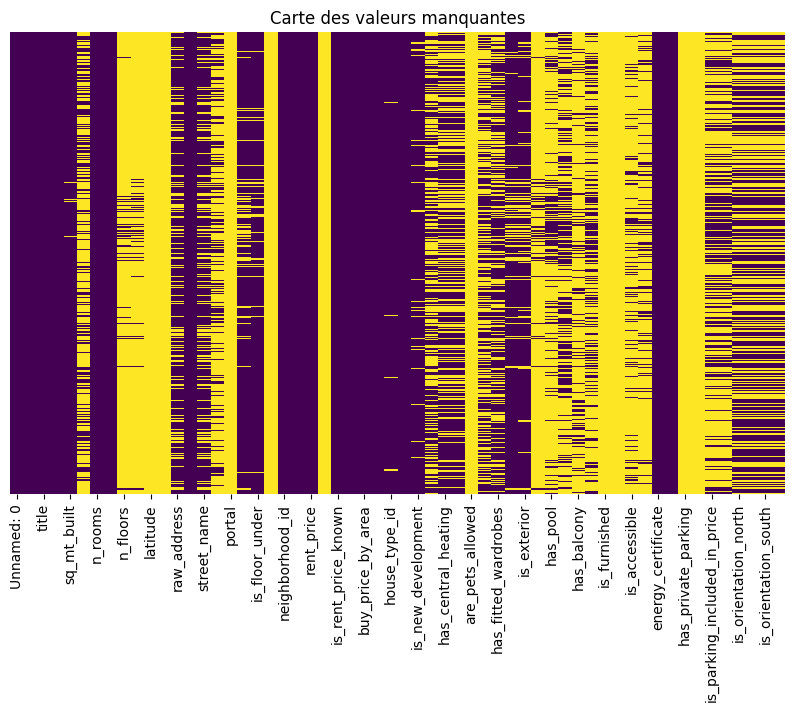


Statistiques descriptives :
          buy_price   sq_mt_built
count  2.174200e+04  21616.000000
mean   6.537356e+05    146.920892
std    7.820821e+05    134.181865
min    3.600000e+04     13.000000
25%    1.980000e+05     70.000000
50%    3.750000e+05    100.000000
75%    7.636000e+05    162.000000
max    8.800000e+06    999.000000


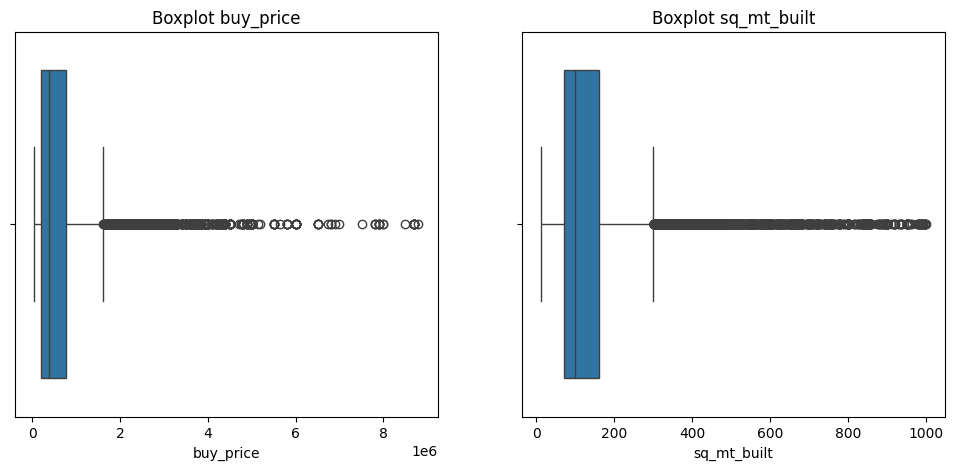

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du dataset
df = pd.read_csv('data\houses_Madrid.csv')

# --- 1. Détection des valeurs manquantes ---
print("Dimensions du dataset :", df.shape)
missing_ratio = df.isna().mean() * 100
print("\nPourcentage de valeurs manquantes par colonne (>0%) :")
print(missing_ratio[missing_ratio > 0].sort_values(ascending=False))

# Visualisation rapide des manques
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Carte des valeurs manquantes")
plt.show()

# --- 2. Détection des anomalies (Outliers) ---
# On se concentre sur les variables numériques clés : prix et surface
cols_num = ['buy_price', 'sq_mt_built']
print("\nStatistiques descriptives :")
print(df[cols_num].describe())

# Boxplots pour visualiser les valeurs extrêmes
plt.figure(figsize=(12, 5))
for i, col in enumerate(cols_num):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')
plt.show()

In [34]:
# --- 1. Suppression des colonnes inutiles ou trop vides ---
# Suppression des colonnes avec > 50% de vide et identifiants/textes inutiles pour le modèle
cols_to_drop = [
    'id', 'title', 'subtitle', 'raw_address', 'street_name', 'street_number', 
    'portal', 'door', 'is_exact_address_hidden',
    'rent_price', 'rent_price_by_area', 'is_rent_price_known', # On se focus sur la vente (buy_price)
    'sq_mt_allotment', 'parking_price' # Trop de NaNs
]
# Ajout des colonnes détectées comme très vides (>50%)
cols_to_drop += list(missing_ratio[missing_ratio > 50].index)
# On garde seulement les colonnes qui existent encore
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

df_clean = df.drop(columns=cols_to_drop)

# --- 2. Traitement des Anomalies ---
# Suppression des lignes sans prix de vente ou prix incohérents
df_clean = df_clean.dropna(subset=['buy_price'])
df_clean = df_clean[df_clean['buy_price'] > 10000] # Filtre prix minimum basique

# --- 3. Imputation des valeurs manquantes restantes ---

# Pour les numériques : Imputation par la médiane
num_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Pour les booléens/catégorielles binaires : On suppose que NaN = False (0)
# (Ex: si 'has_ac' est vide, on suppose qu'il n'y en a pas)
bool_cols = [c for c in df_clean.columns if c.startswith('has_') or c.startswith('is_')]
for col in bool_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(False).astype(int) # Convertit True/False en 1/0

# Pour les autres catégorielles : Imputation par le Mode (valeur la plus fréquente)
cat_cols = df_clean.select_dtypes(include=['object']).columns
for col in cat_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

print("Valeurs manquantes après nettoyage :", df_clean.isna().sum().sum())

Valeurs manquantes après nettoyage : 0


C:\Users\inesl\AppData\Local\Temp\ipykernel_19832\1176648026.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean[col] = df_clean[col].fillna(False).astype(int) # Convertit True/False en 1/0
C:\Users\inesl\AppData\Local\Temp\ipykernel_19832\1176648026.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean[col] = df_clean[col].fillna(False).astype(int) # Convertit True/False en 1/0
C:\Users\inesl\AppData\Local\Temp\ipykernel_19832\1176648026.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and 

In [35]:
from sklearn.preprocessing import LabelEncoder

# --- Label Encoding (pour Energy Certificate et Neighborhood) ---
le = LabelEncoder()

# Energy Certificate (Ordinal : A > B > C...)
if 'energy_certificate' in df_clean.columns:
    df_clean['energy_certificate_encoded'] = le.fit_transform(df_clean['energy_certificate'].astype(str))
    df_clean = df_clean.drop('energy_certificate', axis=1)

# Neighborhood / District (Beaucoup de valeurs uniques, Label Encoding est plus compact que OneHot)
for col in ['neighborhood_id', 'operation']: # 'operation' est souvent 'sale' ou 'rent'
    if col in df_clean.columns:
        df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
        df_clean = df_clean.drop(col, axis=1)

# --- One-Hot Encoding (Dummies) pour le reste ---
# Convertit automatiquement les colonnes 'object' restantes
df_final = pd.get_dummies(df_clean, drop_first=True)

print("Taille finale du dataset :", df_final.shape)
print(df_final.head())

Taille finale du dataset : (21742, 45)
   Unnamed: 0  sq_mt_built  n_rooms  n_bathrooms  is_floor_under  buy_price  \
0           0         64.0        2          1.0               0      85000   
1           1         70.0        3          1.0               0     129900   
2           2         94.0        2          2.0               0     144247   
3           3         64.0        2          1.0               1     109900   
4           4        108.0        2          2.0               0     260000   

   buy_price_by_area  is_buy_price_known  is_renewal_needed  \
0               1328                   1                  0   
1               1856                   1                  1   
2               1535                   1                  0   
3               1717                   1                  0   
4               2407                   1                  0   

   is_new_development  ...  floor_Entreplanta interior  floor_Semi-sótano  \
0                   0  ...    

Dimensions du dataset : (21742, 45)

Pourcentage de valeurs manquantes par colonne (>0%) :
Series([], dtype: float64)


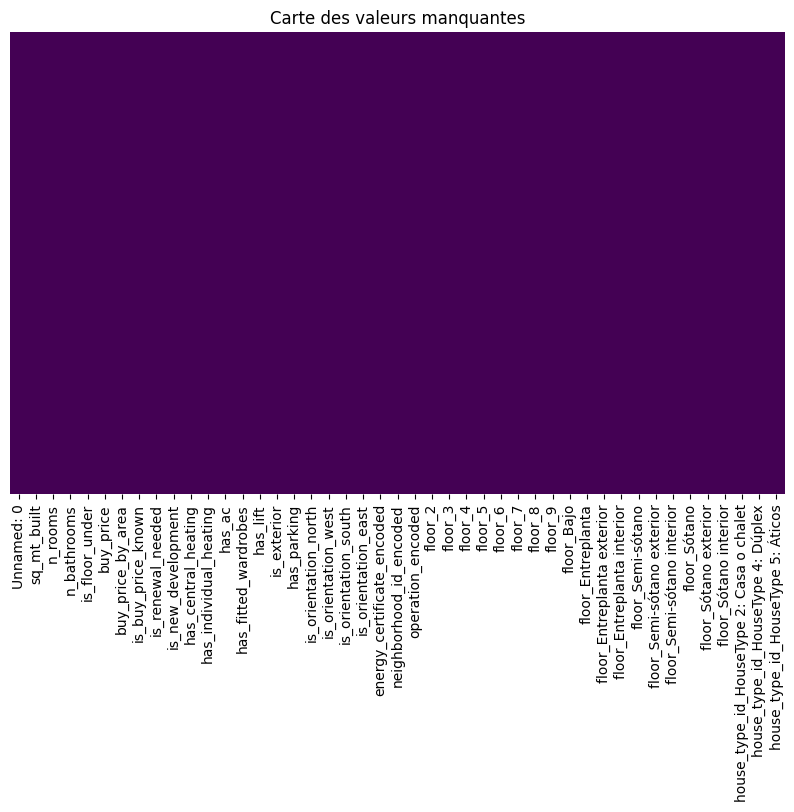


Statistiques descriptives :
          buy_price   sq_mt_built
count  2.174200e+04  21742.000000
mean   6.537356e+05    146.648974
std    7.820821e+05    133.839872
min    3.600000e+04     13.000000
25%    1.980000e+05     70.000000
50%    3.750000e+05    100.000000
75%    7.636000e+05    162.000000
max    8.800000e+06    999.000000


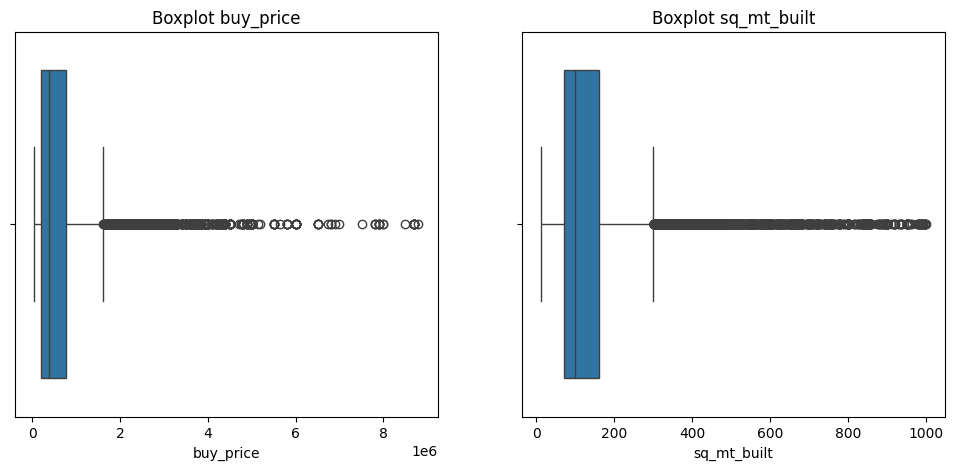

In [36]:

# --- 1. Détection des valeurs manquantes ---
print("Dimensions du dataset :", df_final.shape)
missing_ratio = df_final.isna().mean() * 100
print("\nPourcentage de valeurs manquantes par colonne (>0%) :")
print(missing_ratio[missing_ratio > 0].sort_values(ascending=False))

# Visualisation rapide des manques
plt.figure(figsize=(10, 6))
sns.heatmap(df_final.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Carte des valeurs manquantes")
plt.show()

# --- 2. Détection des anomalies (Outliers) ---
# On se concentre sur les variables numériques clés : prix et surface
cols_num = ['buy_price', 'sq_mt_built']
print("\nStatistiques descriptives :")
print(df_final[cols_num].describe())

# Boxplots pour visualiser les valeurs extrêmes
plt.figure(figsize=(12, 5))
for i, col in enumerate(cols_num):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x=df_final[col])
    plt.title(f'Boxplot {col}')
plt.show()

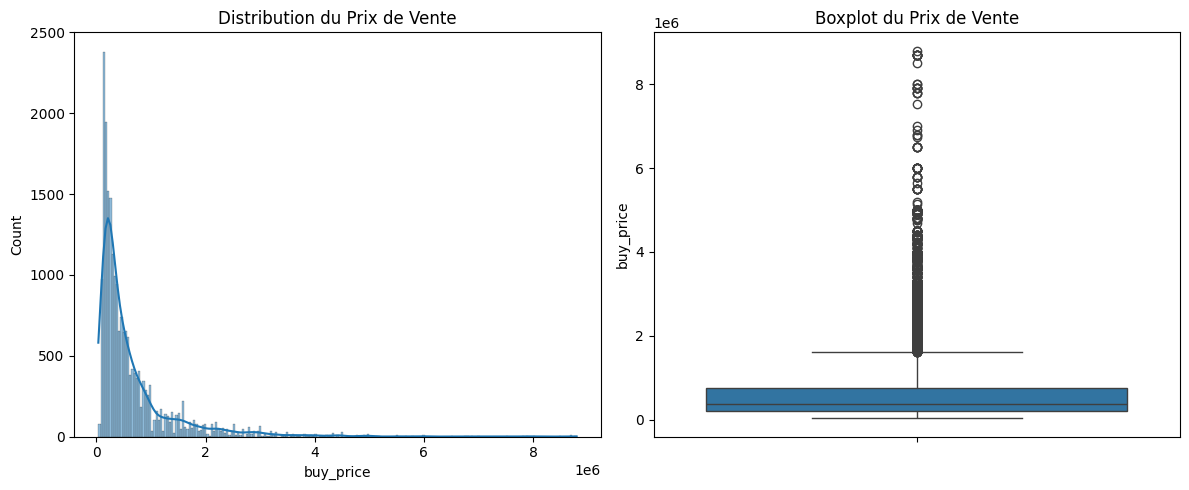

Statistiques de Buy_Price (en €) :
count       21,742.00
mean       653,735.65
std        782,082.07
min         36,000.00
25%        198,000.00
50%        375,000.00
75%        763,600.00
max      8,800,000.00
Name: buy_price, dtype: object


In [37]:
# Distribution du prix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_final['buy_price'], kde=True)
plt.title('Distribution du Prix de Vente')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_final['buy_price'])
plt.title('Boxplot du Prix de Vente')
plt.tight_layout()
plt.show()

# Statistiques clés du prix
print("Statistiques de Buy_Price (en €) :")
print(df_final['buy_price'].describe().apply(lambda x: f"{x:,.2f}"))

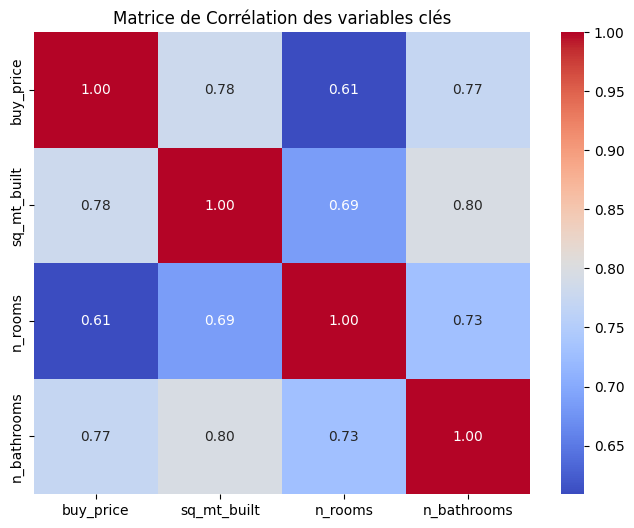

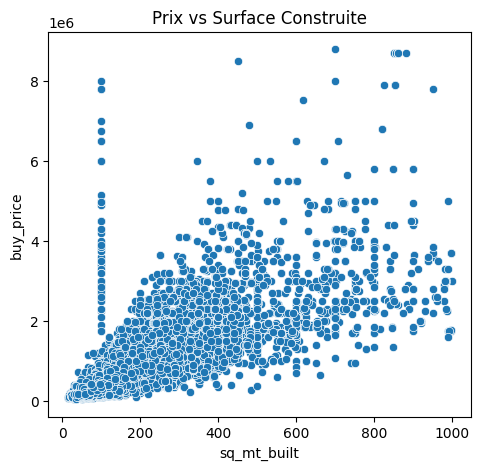

In [38]:
# Matrice de corrélation
cols_corr = ['buy_price', 'sq_mt_built', 'n_rooms', 'n_bathrooms']  
corr_matrix = df_final[cols_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation des variables clés')
plt.show()

# Relation Prix vs Surface
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='sq_mt_built', y='buy_price', data=df_final)
plt.title('Prix vs Surface Construite')
plt.show()
# Prix moyen par Type de Maison
if 'house_type_id_HouseType 1: Pisos' in df_final.columns:
    # Pour 'house_type_id_HouseType 1: Pisos' (vs autres types, après One-Hot Encoding avec drop_first=True)
    # Les autres colonnes OHE sont trop nombreuses, on se concentre sur une agrégation
    
    # Récupérer la colonne type de maison avant OHE pour un meilleur visuel
    df_temp = pd.read_csv('houses_Madrid.csv')[['house_type_id']]
    df_temp = df_temp.dropna().merge(df_final[['buy_price']], left_index=True, right_index=True)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='house_type_id', y='buy_price', data=df_temp)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, df_temp['buy_price'].quantile(0.95)) # Limiter l'axe Y pour la clarté
    plt.title('Prix de Vente par Type de Maison (95% des données)')
    plt.tight_layout()
    plt.show()